In [1]:
import tensorflow as tf
from tensorflow import keras
import glob
import os
import random
import shutil
import itertools
import numpy as np
from sklearn.metrics import confusion_matrix
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import plotutils
from plotutils import plot_confusion_matrix, plot_images


# Cats and dogs with VGG16
## Environment setup

### GPU setup

In [2]:
print("Built with CUDA: ", tf.test.is_built_with_cuda())
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPU available", len(gpus))
tf.config.experimental.set_memory_growth(gpus[0], True)

Built with CUDA:  True
Num GPU available 1


### Data setup

In [3]:

train_path = 'data/slim/train/'
valid_path = 'data/slim/valid/'
test_path = 'data/slim/test/'
vgg16_preprocessing_function = tf.keras.applications.vgg16.preprocess_input
target_size = (224,224)
classes = ['cat', 'dog']
batch_size = 10

train_batches = ImageDataGenerator(preprocessing_function=vgg16_preprocessing_function).flow_from_directory(
    directory=train_path,
    target_size=target_size,
    classes=classes,
    batch_size=batch_size
)
valid_batches = ImageDataGenerator(preprocessing_function=vgg16_preprocessing_function).flow_from_directory(
    directory=valid_path,
    target_size=target_size,
    classes=classes,
    batch_size=batch_size
)
# Non vogliamo che il test_batch sia mescolato perchè vogliamo potervi accedere quando facciamo la
# rappresentazione grafica tramite confusion matrix
test_batches = ImageDataGenerator(preprocessing_function=vgg16_preprocessing_function).flow_from_directory(
    directory=test_path,
    target_size=target_size,
    classes=classes,
    batch_size=batch_size,
    shuffle=False
)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


## VGG16 model building

In [4]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

### Original VGG16 summary

In [5]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
new_model = Sequential()
for layer in vgg16_model.layers[:-1]:
    new_model.add(layer)

### VGG16 without predictions summary

In [7]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [8]:
for layer in new_model.layers:
    layer.trainable = False

In [9]:
new_model.add(Dense(units=2, activation='softmax'))


### VGG16 custom for dog/cats summary

In [10]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

## VGG16 model training

In [11]:
new_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
new_model.fit(x=train_batches, validation_data=valid_batches, epochs=5, verbose=2)

Epoch 1/5
100/100 - 17s - loss: 0.2876 - accuracy: 0.8850 - val_loss: 0.0912 - val_accuracy: 0.9650
Epoch 2/5
100/100 - 11s - loss: 0.0966 - accuracy: 0.9590 - val_loss: 0.0551 - val_accuracy: 0.9850
Epoch 3/5
100/100 - 11s - loss: 0.0593 - accuracy: 0.9800 - val_loss: 0.0452 - val_accuracy: 0.9850
Epoch 4/5
100/100 - 11s - loss: 0.0382 - accuracy: 0.9910 - val_loss: 0.0362 - val_accuracy: 0.9850
Epoch 5/5
100/100 - 11s - loss: 0.0280 - accuracy: 0.9940 - val_loss: 0.0346 - val_accuracy: 0.9850



## VGG16 model prediction


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

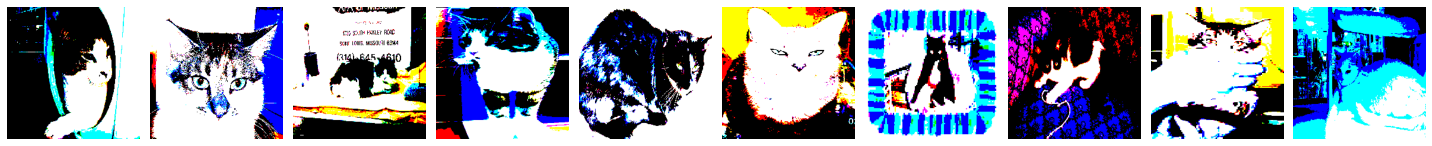

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [13]:
test_imgs, test_labels = next(test_batches)
plot_images(test_imgs)
print(test_labels)

In [14]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [15]:
predictions = new_model.predict(x=test_batches, verbose=0)

In [16]:
np.round(predictions)


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [17]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix without normalization
[[50  0]
 [ 0 50]]


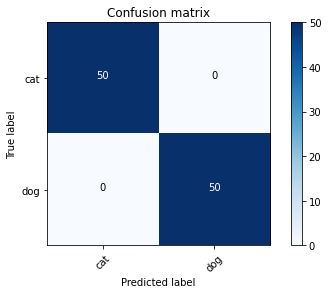

In [18]:
cm_plot_labels = test_batches.class_indices.keys()
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
plot_confusion_matrix(cm, classes=cm_plot_labels, title="Confusion matrix")